In [2]:
#input library
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
#Define Configuration
IMG_SIZE = 64 #Image size()
NUM_CLASSES = 3 # Circle, Triangle,Square
BATCH_SIZE = 16 # 16,32-->1 false,but all predictions are correct after add more layer 
EPOCHS = 30 #20-->Accuracy 77.62%,30-->80%
LEARNING_RATE =0.0001
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2 # Test = 1 -(train+val)

In [4]:
#Dataset Directory Setup
dataset_dir = "./shape_classifier_dataset"
os.makedirs(dataset_dir, exist_ok = True)

In [5]:
#function for generating Synthetic Images
def generate_shape_image(shape, img_size = IMG_SIZE, random_size = False, random_rotation = False):
    img = Image.new("RGB",(img_size, img_size), "white")
    draw = ImageDraw.Draw(img)
    
    size = random.randint(15,30)
    rotation = random.randint(0,360)
    x,y = random.randint(10,30), random.randint(10,30)
    if shape == "Circle":
        draw.ellipse([x, y, x+size, y+size], fill = "black")
    elif shape == "Square":
        draw.rectangle([x, y, x+size, y+size], fill = "black")
    elif shape == "Triangle":
        points = [(x, y+size), (x + size/2, y), (x+size, y+size)]
        draw.polygon(points, fill = "black")
    img= img.rotate(rotation)
    return img

In [6]:
#Generate and Save Dataset
shapes = ["Circle", "Square", "Triangle"]
num_image_per_class = 700

def create_dataset():
    for shape in shapes:
        shape_dir = os.path.join(dataset_dir, shape)
        os.makedirs(shape_dir, exist_ok = True)
        
        for i in range(num_image_per_class):
            img = generate_shape_image(shape, random_size = True, random_rotation = True)
            img.save(os.path.join(shape_dir, f"{shape}_{i}.png"))

create_dataset()

In [7]:
#Custom Pytorch Dataset Class
class ShapeDataset(Dataset):
    def __init__(self, root_dir, transform = None): #constructor Method
        self.root_dir = root_dir #Path to main dataset directory
        self.transform = transform #optimal transformation (e.g., resizing)
        self.data = [] #list to store inmage file paths
        self.label = [] #list to store corresponding lables
        
        for idx, shape in enumerate(shapes): #loop through shape categories
            shape_dir = os.path.join(root_dir, shape) #Path to each shape folder(e.g., dataset/circle/img0.png)
            for img_name in os.listdir(shape_dir): #list all image file for individual folder
                self.data.append(os.path.join(shape_dir, img_name)) #store image file
                self.label.append(idx) #store label
                
                
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data[idx]
        img = Image.open(img_path).convert("RGB")
        label = self.label[idx]
        
        if self.transform:
            img =  self.transform(img)
            
        return img, label

In [8]:
#Data Transfomations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
    ])

In [9]:
#load Dataset and Create Dataloaders
dataset = ShapeDataset(dataset_dir, transform = transform)
train_size = int(TRAIN_RATIO * len(dataset))
val_size = int(VAL_RATIO * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle =True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle =False)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle =False)

In [16]:
#Define CNN Model
class ShapeClassifierCNN(nn.Module):#new class
    def __init__(self): #constructor method
        super(ShapeClassifierCNN, self).__init__() #parent class's constructor
        #Convolutional layer1(Input image with 3 channel(RGB), outputs 16 channels,padding=1-->remain output size same as input)
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding=1) 
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, padding=1)#takes 16 featuremaps --> output 32 feature maps
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding=1)
        #256 is commonly used: 4096-->256
        self.fc1 = nn.Linear(64 * 8 * 8, 256) #64 feature maps of -->output 256 neurons
        self.fc2 = nn.Linear(256, NUM_CLASSES) #256--> number of classes(shapes)
        self.pool = nn.MaxPool2d(2, 2) #2x2 max pooling
        self.relu = nn.ReLU()
    
    #data flows through the network
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))#input:[batch,3,64,64],output after pooling:[batch,16,32,32],maxpool(2,2) cut in half
        x = self.pool(self.relu(self.conv2(x)))#input:[batch,16,32,32],output after pooling:[batch,32,16,16]
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1) # Flatten the tensor from shape[batch,32,16,16] to [batch,8192]
        x = self.relu(self.fc1(x)) # Fully Connected Layer + ReLU. output[batch,128]
        x = self.fc2(x) #Shape:[batch,Num_class]
        return x #return the final output for loss computation or prediction

In [17]:
#Setup loss funciton and optimizer
model = ShapeClassifierCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [18]:
#Training Loop
def train_model(model, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

train_model(model, train_loader, val_loader, EPOCHS)

Epoch 1/30, Loss: 1.0811
Epoch 2/30, Loss: 0.9392
Epoch 3/30, Loss: 0.8744
Epoch 4/30, Loss: 0.8470
Epoch 5/30, Loss: 0.8344
Epoch 6/30, Loss: 0.8098
Epoch 7/30, Loss: 0.8024
Epoch 8/30, Loss: 0.7628
Epoch 9/30, Loss: 0.7335
Epoch 10/30, Loss: 0.6971
Epoch 11/30, Loss: 0.6442
Epoch 12/30, Loss: 0.5848
Epoch 13/30, Loss: 0.5534
Epoch 14/30, Loss: 0.4971
Epoch 15/30, Loss: 0.4539
Epoch 16/30, Loss: 0.4284
Epoch 17/30, Loss: 0.3926
Epoch 18/30, Loss: 0.3502
Epoch 19/30, Loss: 0.3067
Epoch 20/30, Loss: 0.2779
Epoch 21/30, Loss: 0.2354
Epoch 22/30, Loss: 0.1959
Epoch 23/30, Loss: 0.1759
Epoch 24/30, Loss: 0.1327
Epoch 25/30, Loss: 0.1226
Epoch 26/30, Loss: 0.0955
Epoch 27/30, Loss: 0.0803
Epoch 28/30, Loss: 0.0664
Epoch 29/30, Loss: 0.0527
Epoch 30/30, Loss: 0.0472


In [19]:
#Model Evaluation on Test Set
def evaluate_model(model, test_loader):
    model.eval()
    correct, total =0, 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs =  model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    return all_preds, all_labels

preds, labels = evaluate_model(model, test_loader)

Test Accuracy: 95.71%


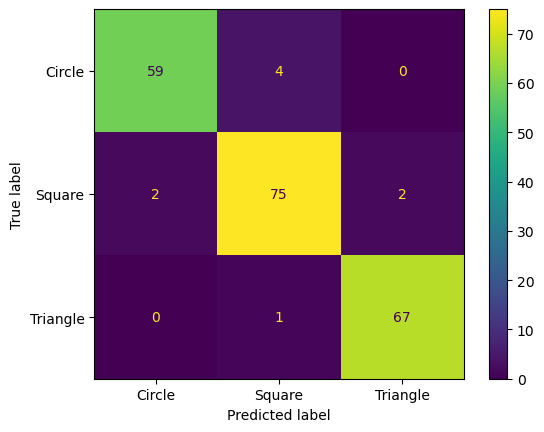

In [20]:
#Confusion Matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(cm, display_labels = shapes)
disp.plot()
plt.show()

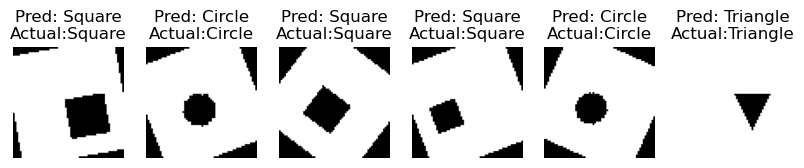

In [21]:
#Visualize Sample Predictions
def visualize_predictions(model, test_loader, class_names, num_images):
    model.eval()
    images, labels = next(iter(test_loader))
    
    #Move data to CPU if necessary
    images = images.cpu()
    labels = labels.cpu()
    
    #Get model predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
    #plot sample predictions
    fig, axes = plt.subplots(1, num_images, figsize=(10,2))
    for i in range(num_images):
        img = images[i].permute(1,2,0).numpy() # Convert from (C,H,W)
        img = np.clip(img,0,1) #Ensure values are in valid range for imshow
        axes[i].imshow(img)
        axes[i].set_title(f'Pred: {class_names[predicted[i].item()]}\nActual:{class_names[labels[i].item()]}')
        axes[i].axis('off')
    plt.show()
    
visualize_predictions(model, test_loader, shapes, 6)